![](../storage/banners/14_iss.png)

### <span style="color:#0ab49a">Определение</span> <span style="color:#A254FC">движения</span> 

In [69]:
import os
import cv2
import gradio as gr
import numpy as np
from art import tprint
import matplotlib.pyplot as plt


# Номер эксперимента: 1 - 8_40, 2 - 9_02
N_exp = 1

# Номер камеры: 1, 2, 3
N_cam = 1

def get_filenames(N_cam, N_exp):
    be = "e"
    bc = "c"
    return f"full_videos/iss_{be}{N_exp}_{bc}{N_cam}.MP4", f"iss_{be}{N_exp}_{bc}{N_cam}_crop.mp4", f"iss_{be}{N_exp}_{bc}{N_cam}_cut.mp4", f"iss_{be}{N_exp}_{bc}{N_cam}_speed.mp4", f"iss_{be}{N_exp}_{bc}{N_cam}_result.mp4"

def get_dt(N_cam, acceleration):
    return acceleration / 50  # Почему 50? Надо проверить кадры в секунду у каждого видео

acceleration = 20
path = "Resources/files/"
filename, filename_cropped, filename_cutted, filename_speed, filename_output = get_filenames(N_cam, N_exp)

#### <span style="color:#5b77a9">Подготовка видео</span> 

In [ ]:
# Обрезка кадров
if N_exp == 1:
    if N_cam == 1:
        x = 900
        y = 0
        out_w = 300
        out_h = 450
    elif N_cam == 2:
        x = 750 
        y = 0
        out_w = 500
        out_h = 700
    else:
        x = 50
        y = 0
        out_w = 500
        out_h = 900
else:
    if N_cam == 1:
        x = 900 
        y = 100 
        out_w = 300  
        out_h = 350 
    elif N_cam == 2:
        x = 750
        y = 0
        out_w = 500
        out_h = 700
    else:
        x = 50
        y = 0
        out_w = 900
        out_h = 700
os.system(f'ffmpeg -i {path+filename} -vf "crop={out_w}:{out_h}:{x}:{y}" {path+filename_cropped}')

In [44]:
# Помощь в этих ваших минутах/секундах
m1, s1 = 0, 40
m2, s2 = 5, 11

ds = m2*60 + s2 - m1*60 - s1
print(f"{ds // 60}:{ds % 60}")

4:31


In [ ]:
# Обрезка таймлайна
if N_exp == 1:
    if N_cam == 1:  # 00:50 убирает руку - 10 секунд после руки
        t0 = f"01:00"
        dt = f"04:50"  # Суммарно до 05:50
    elif N_cam == 2:  # 00:50 убирает руку - 10 секунд после руки
        t0 = f"01:00"
        dt = f"04:40"  # Суммарно до 05:40
    else:
        t0 = f"00:48"  # Не видно руку
        dt = f"03:03"  # Суммарно до 03:51
else:
    if N_cam == 1:  # 00:43 убирает руку - 7 секунд после руки
        t0 = f"00:50"
        dt = f"05:36"  # Суммарно до 06:26
    elif N_cam == 2:  # 00:30 убирает руку - 7 секунд после руки
        t0 = f"00:37"
        dt = f"05:43"  # Суммарно до 06:20
    else:  # 00:34 убирает руку - 7 секунд после руки
        t0 = f"00:40"
        dt = f"04:31"
os.system(f'ffmpeg -ss 00:{t0}.0 -i {path + filename_cropped} -c copy -t 00:{dt}.0 {path + filename_cutted}')

In [ ]:
# Ускорение
os.system(f'ffmpeg -i {path + filename_cutted} -an -vf setpts=0.05*PTS {path + filename_speed}')

In [56]:
# Удаление ненужных файлов
os.remove(path + filename_cropped)
os.remove(path + filename_cutted)

#### <span style="color:#5b77a9">Создание обучающей выборки</span> 

In [ ]:
from PIL import Image 
import matplotlib.pyplot as plt

extrapath = ["train", "val"][0]
 
# creating a object 
for i in range(0, 25):
    im = Image.open(f"Resources/files/for_train/{extrapath}/images/{i+1}.jpg") 
    with open(f"Resources/files/for_train/{extrapath}/labels/{extrapath[0]}_{i+1}.txt", 'r') as f:
        xywh = f.read().split()
        xx = [float(xywh[1]) - float(xywh[3])/2, float(xywh[1]) + float(xywh[3])/2]
        yy = [float(xywh[2]) - float(xywh[4])/2, float(xywh[2]) + float(xywh[4])/2]
        print(f"{i+1}: Центр [{float(xywh[1])}, {float(xywh[2])}], Диаметр: {float(xywh[3])}")
    
    
    with open(f"Resources/files/for_train/{extrapath}/labels/{i+1}.txt", 'w') as f:
        width, height = im.size
        f.write(f"{xywh[0]} {float(xywh[1])/width} {float(xywh[2])/height} {float(xywh[3])/width} {float(xywh[4])/height}")

    plt.imshow(im)
    plt.plot([xx[0], xx[1]], [yy[0], yy[0]], c='r')
    plt.plot([xx[0], xx[1]], [yy[1], yy[1]], c='r')
    plt.plot([xx[0], xx[0]], [yy[0], yy[1]], c='r')
    plt.plot([xx[1], xx[1]], [yy[0], yy[1]], c='r')
    plt.show()

#### <span style="color:#5b77a9">Обработка видео: YOLO-8</span>   

In [57]:
from ultralytics import YOLO
import cv2
import numpy as np

# Загрузка модели YOLOv8
# model = YOLO('yolov8n.pt')
model = YOLO('my_yolo_1_500.pt')

# Список цветов для различных классов
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (128, 0, 128), (0, 128, 128), (0, 0, 128), (72, 61, 139),
    (47, 79, 79), (47, 79, 47), (0, 206, 209), (148, 0, 211), (255, 20, 147)
]

##### **Обучение**

Оптимум: 500 эпох

In [ ]:
model.train(data=path + "for_train/fortrain.yaml", epochs=150)

In [ ]:
extrapath = ["train", "val"][0]
b = []
n = 5

for i in range(n):
    b += [model.predict(f"Resources/files/for_train/{extrapath}/images/{i+1}.jpg")[0]]

In [ ]:
[len(b[i].boxes) for i in range(n)]

In [4]:
model.save('my_yolo_1_500.pt')

##### **Предсказание**

In [68]:
# Открытие исходного видеофайла
capture = cv2.VideoCapture(path + filename_speed)

# Чтение параметров видео
fps = int(capture.get(cv2.CAP_PROP_FPS))
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Настройка выходного файла
output_video_path = path + filename_output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

count = 0 
boxes_in_frames = []
f = open(path + f"boxes_{N_exp}_({N_cam}).txt", 'w')
while True:
    # Захват кадра
    ret, frame = capture.read()
    count += 1
    print(f"Кадр {count}")
    if not ret: # or count > 20:
        break

    # Обработка кадра с помощью модели YOLO
    results = model(frame)[0]

    # Получение данных об объектах
    boxes_in_frame = []
    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)
    # Рисование рамок и подписей на кадре
    for class_id, box, conf in zip(classes, boxes, results.boxes.conf):
        if conf > 0.5:
            class_name = classes_names[int(class_id)]
            color = colors[int(class_id) % len(colors)]
            x1, y1, x2, y2 = box
            boxes_in_frame += [box]
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    boxes_in_frames += [boxes_in_frame]

    # Запись положения найденного тела
    n = len(boxes_in_frame)
    txt = f"{n} "
    for i in range(n):
        for j in range(4):
            txt += f"{boxes_in_frame[i][j]} "
    f.write(txt + "\n")

    # Запись обработанного кадра в выходной файл
    writer.write(frame)

# Освобождение ресурсов и закрытие окон
capture.release()
writer.release()
f.close()

Кадр 1

0: 640x480 1 special ball, 478.1ms
Speed: 11.0ms preprocess, 478.1ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 480)
Кадр 2

0: 640x480 1 special ball, 126.1ms
Speed: 5.0ms preprocess, 126.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
Кадр 3

0: 640x480 1 special ball, 135.6ms
Speed: 7.3ms preprocess, 135.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Кадр 4

0: 640x480 2 special balls, 128.4ms
Speed: 3.8ms preprocess, 128.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
Кадр 5

0: 640x480 1 special ball, 103.8ms
Speed: 15.2ms preprocess, 103.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
Кадр 6

0: 640x480 1 special ball, 90.1ms
Speed: 15.6ms preprocess, 90.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Кадр 7

0: 640x480 1 special ball, 91.5ms
Speed: 5.5ms preprocess, 91.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)
Кадр 8

0: 6

##### **Графики движения**

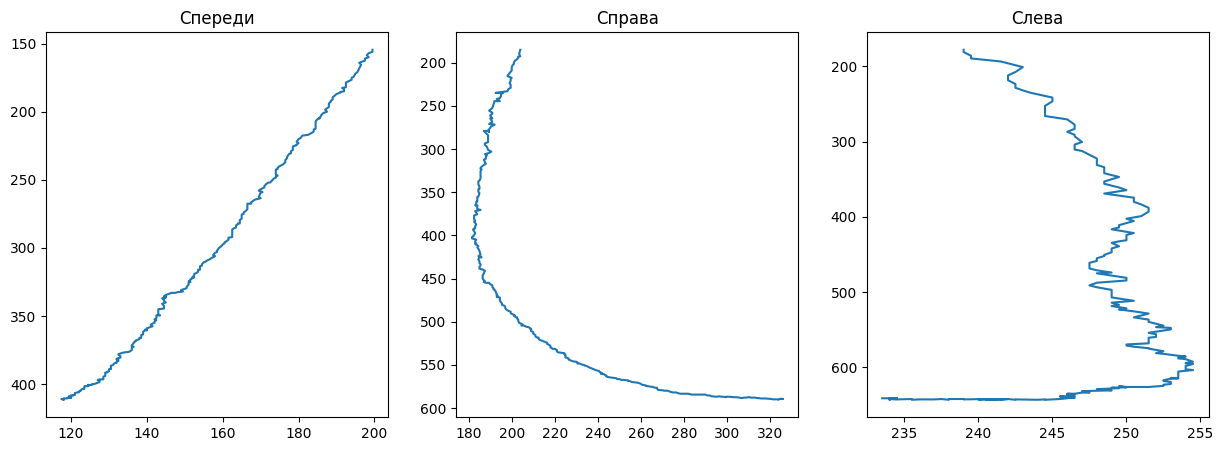

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

x_s, y_s, t_s = [], [], []
xyts = [[], [], []]
t_max = 0.

for N_cam in [1, 2, 3]:
    filename, filename_cropped, filename_cutted, filename_speed, filename_output = get_filenames(N_cam, N_exp)
    dt = get_dt(N_cam, acceleration)
    xyt = []
    t_now = 0.
    with open(path + f"boxes_{N_exp}_({N_cam}).txt", 'r') as f:
        for line in f:
            t_now += dt
            t_max = max(t_now, t_max)
            tmp = line.split()

            # Хитрый выбор нужных боксов - среди всех боксов на картинке выбираются близкие к предыдущим по времени
            if int(tmp[0]) == 1:
                xyt.append([(int(tmp[1]) + int(tmp[3])) / 2, (int(tmp[2]) + int(tmp[4])) / 2, t_now])
            elif int(tmp[0]) >= 1:
                xy_s = []
                ranges = []
                for i in range(int(tmp[0])):
                    xy_s.append([(int(tmp[1 + i*4]) + int(tmp[3 + i*4])) / 2, (int(tmp[2 + i*4]) + int(tmp[4 + i*4])) / 2])
                    ranges.append(np.linalg.norm(np.array(xy_s[-1]) - np.array(xyt[-1][0:2])))
                xyt.append(xy_s[ranges.index(min(ranges))] + [t_now])

    # Постобработка
    xyts[N_cam - 1] = xyt
    x = [xyt[i][0] for i in range(len(xyt))]
    y = [xyt[i][1] for i in range(len(xyt))]
    t = [xyt[i][2] for i in range(len(xyt))]
    x_s.append(x)
    y_s.append(y)
    t_s.append(t)
    
    axs[N_cam - 1].plot(x, y)
    axs[N_cam - 1].invert_yaxis()
    axs[N_cam - 1].set_title(["Спереди", "Справа", "Слева"][N_cam - 1])

plt.show()

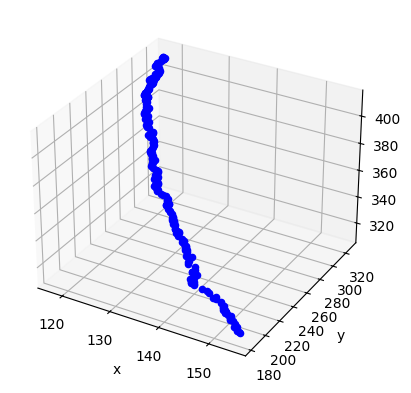

In [71]:
# 3D-проекция
n_res = min(len(x_s[0]), len(x_s[1]), len(x_s[2]))
x_s = np.array([np.array([x_s[0][i], x_s[1][i], x_s[2][i]]) for i in range(n_res)])
y_s = np.array([np.array([y_s[0][i], y_s[1][i], y_s[2][i]]) for i in range(n_res)])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(n_res):
    ax.scatter(x_s[i][0], x_s[i][1], y_s[i][0], c='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [9]:
"""
xyts[i][j][k]:
    i - 0,1,2 - вид Спереди, Справа, Слева
    j - 0..N - отрезки времени
    k - 0,1,2 - x, y, t
"""
t_now = 0.
t_xy_new = []
indexes = [0, 0, 0]
dt = get_dt(N_cam=1, acceleration=acceleration)
for i in range(int(t_max // dt)):
    t_now += dt
    tmp = []
    
    t_xy_new.append([t_now] + tmp)

3

#### <span style="color:#5b77a9">К ежам по чертежам</span>   

In [ ]:
# Центр масс
def xy_to_angle(N_cam, x, y):
    if N_cam == 1:
        pass